### Introduction

This notebook focuses on predicting the lipophilicity (logD) of molecules, a critical property in drug design that influences absorption, distribution, metabolism, and excretion (ADME) of compounds. Lipophilicity is measured as the octanol/water distribution coefficient (logD at pH 7.4).

Predicting lipophilicity has several practical applications:
- **Drug Design:** Optimizing lipophilicity can improve a drug’s bioavailability and efficacy.
- **Toxicology:** Assessing lipophilicity can help predict the potential toxicity of compounds, as highly lipophilic compounds tend to accumulate in fatty tissues.
- **Pharmacokinetics:** Understanding lipophilicity aids in predicting the absorption, distribution, and clearance rates of drugs.

The goal is to use supervised machine-learning models to predict the lipophilicity of molecules based on their molecular descriptors. Two models are explored: Random Forest and Gradient Boosting Regressors. The effectiveness of these models is assessed using various metrics, including Mean Squared Error (MSE), R-squared (R²), Mean Absolute Error (MAE), Akaike Information Criterion (AIC), and Bayesian Information Criterion (BIC).

### Model Performance Summary

#### Random Forest (using reduced features)
- **Cross-Validation Scores:** [0.6199, 0.5800, 0.5771, 0.5743, 0.5846]
- **Mean Squared Error (MSE):** **0.4532**
- **Root Mean Squared Error (RMSE):** **0.6732**
- **R-squared (R²):** **0.6151**
- **Mean Absolute Error (MAE):** **0.5259**
- **AIC:** **1426.37**
- **BIC:** **1435.57**

#### Gradient Boosting (using reduced features)
- **Cross-Validation Scores:** [0.6909, 0.6713, 0.6720, 0.6638, 0.6768]
- **Mean Squared Error (MSE):** **0.3524**
- **Root Mean Squared Error (RMSE):** **0.5937**
- **R-squared (R²):** **0.7007**
- **Mean Absolute Error (MAE):** **0.4573**
- **AIC:** **1313.24**
- **BIC:** **1322.44**

The Gradient Boosting model demonstrates superior performance over the Random Forest model, as reflected by its lower Mean Squared Error (0.3524 vs. 0.4532) and higher R-squared value (0.7007 vs. 0.6151). Additionally, the Gradient Boosting model achieves better results in terms of Root Mean Squared Error, Mean Absolute Error, AIC, and BIC. The reasons why Gradient Boosting outperforms Random Forest in this context will be discussed at the end of the notebook.



In [ ]:
# Cell 1: Install necessary package
!pip install rdkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 12.7 MB/s eta 0:00:00


In [ ]:
# Cell 2: Import Required Libraries

import pandas as pd
import numpy as np
from rdkit import Chem, RDLogger
from rdkit.Chem import Descriptors
from rdkit.Chem.AllChem import GetMACCSKeysFingerprint, GetMorganFingerprintAsBitVect
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr

RDLogger.DisableLog('rdApp.*')


### Dataset Columns Explanation

This dataset contains the following columns:

- **CMPD_CHEMBLID:** A unique identifier for each compound from the ChEMBL database.
- **exp:** The experimentally determined lipophilicity value (logD at pH 7.4) for each compound.
- **smiles:** The SMILES (Simplified Molecular Input Line Entry System) string representing the molecular structure of each compound. SMILES strings are a way to encode the structure of a molecule in a text format, allowing for computational analysis and descriptor generation.

In [ ]:
# Cell 3: Load data
def load_data(file_path):
    data = pd.read_csv(file_path)
    print(data.head())
    print(data.info())
    return data

file_path2 = 'https://drive.google.com/uc?export=download&id=1rFHDjB25B7GhUvciqHWAtvPjgjDm86wW'
lipophilicity = load_data(file_path2)

   CMPD_CHEMBLID   exp                                             smiles
0   CHEMBL596271  3.54            Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1  CHEMBL1951080 -1.18  COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2     CHEMBL1771  3.69             COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3   CHEMBL234951  3.37  OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4   CHEMBL565079  3.10  Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CMPD_CHEMBLID  4200 non-null   object 
 1   exp            4200 non-null   float64
 2   smiles         4200 non-null   object 
dtypes: float64(1), object(2)
memory usage: 98.6+ KB
None


The `calculate_extended_descriptors` function and subsequent processing steps constitute data cleaning by standardizing and validating SMILES strings, handling missing or invalid data, and ensuring consistent descriptor generation. Invalid SMILES are identified, returning `None` values to prevent errors during descriptor calculation. The function calculates a standardized set of descriptors for each valid SMILES, ensuring uniformity. The descriptors are combined with the original dataset and cleaned by removing rows with missing values, ensuring only complete data is used for modeling.

In [ ]:
# Cell 4: Define function to calculate extended descriptors
def calculate_extended_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        descriptors = {
            'MolWt': Descriptors.MolWt(mol),
            'TPSA': Descriptors.TPSA(mol),
            'NumHAcceptors': Descriptors.NumHAcceptors(mol),
            'NumHDonors': Descriptors.NumHDonors(mol),
            'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
            'NumRings': Descriptors.RingCount(mol),
            'NumHeavyAtoms': Descriptors.HeavyAtomCount(mol),
            'QED': Descriptors.qed(mol),
        }

        maccs = GetMACCSKeysFingerprint(mol)
        for i in range(1, maccs.GetNumBits()):
            descriptors[f'MACCS_{i}'] = maccs.GetBit(i)

        morgan = GetMorganFingerprintAsBitVect(mol, 2, nBits=2048)
        for i in range(morgan.GetNumBits()):
            descriptors[f'Morgan_{i}'] = morgan.GetBit(i)

        return pd.Series(descriptors)
    else:
        return pd.Series({
            'MolWt': None, 'TPSA': None, 'NumHAcceptors': None,
            'NumHDonors': None, 'NumRotatableBonds': None, 'NumRings': None,
            'NumHeavyAtoms': None, 'QED': None
        })


**MACCS Keys:**
- These features indicate the presence or absence of specific substructures within the molecules. Each MACCS key represents a predefined chemical pattern impacting lipophilicity.

**Morgan Fingerprints:**
- The importance of these bits suggests that certain atom environments significantly influence lipophilicity.


In [ ]:
# Cell 5: Apply descriptors calculation
def calculate_descriptors(data):
    descriptors = data['smiles'].apply(calculate_extended_descriptors)
    return pd.concat([descriptors, data[['exp']]], axis=1).dropna()

data = calculate_descriptors(lipophilicity)

Total missing values: 0
Missing values in each column:
 MolWt                0
TPSA                 0
NumHAcceptors        0
NumHDonors           0
NumRotatableBonds    0
                    ..
Morgan_2044          0
Morgan_2045          0
Morgan_2046          0
Morgan_2047          0
exp                  0
Length: 2223, dtype: int64
Number of outliers in each column:
 {'MolWt': 10, 'TPSA': 15, 'NumHAcceptors': 12, 'NumHDonors': 210, 'NumRotatableBonds': 38, 'NumRings': 283, 'NumHeavyAtoms': 13, 'QED': 4, 'exp': 22}


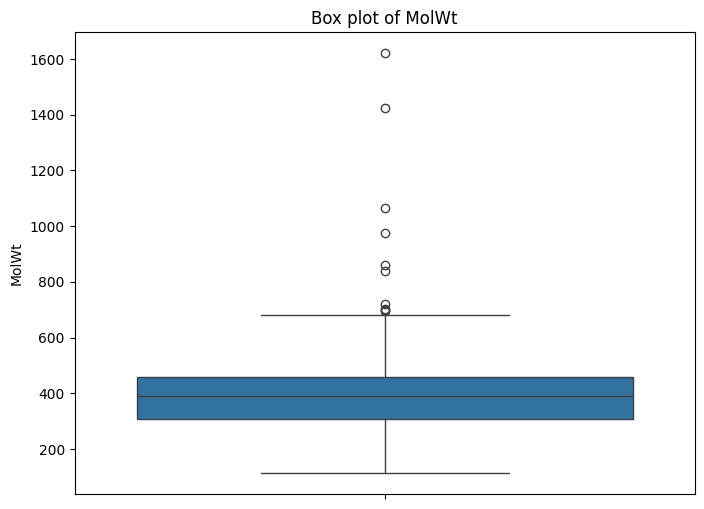

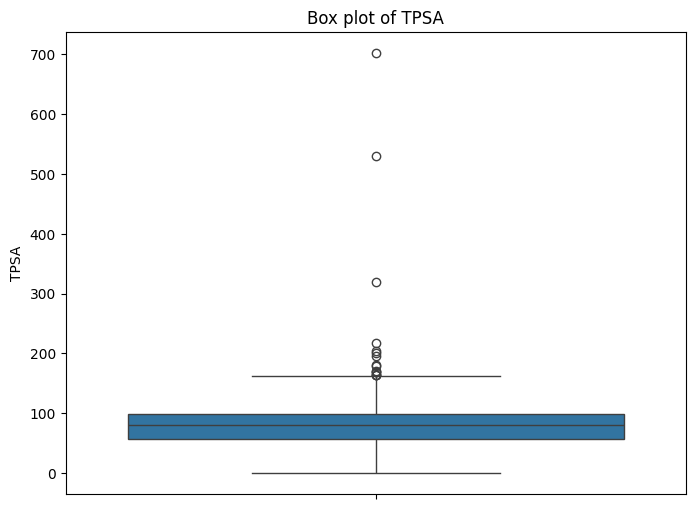

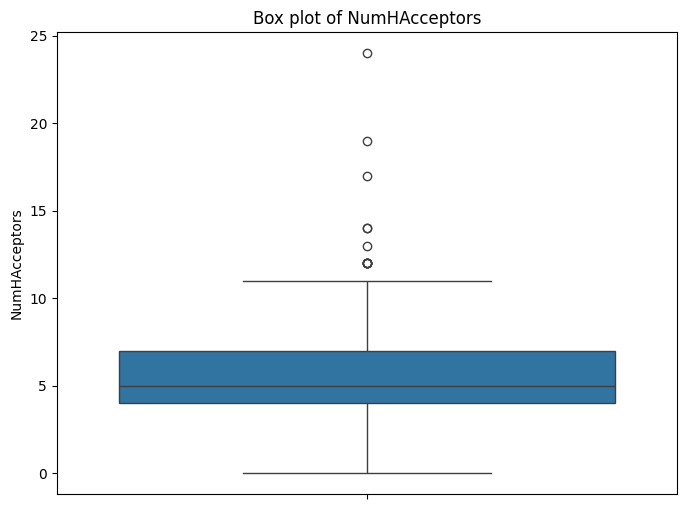

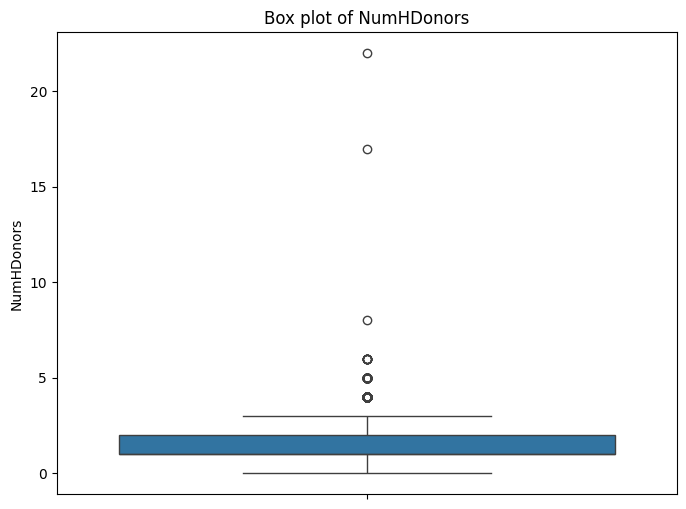

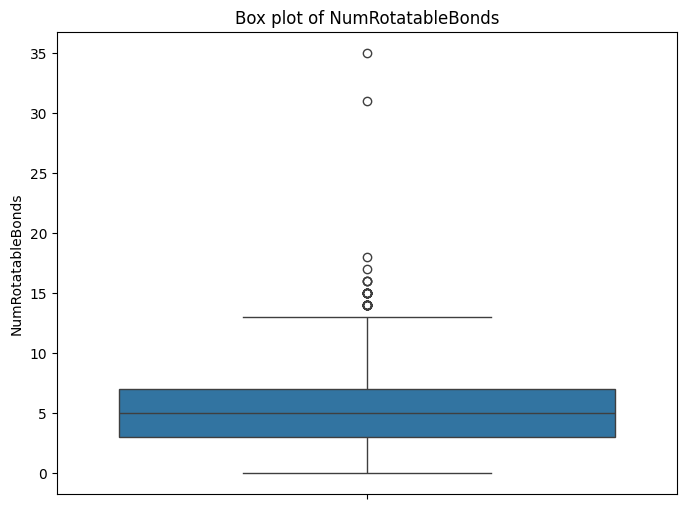

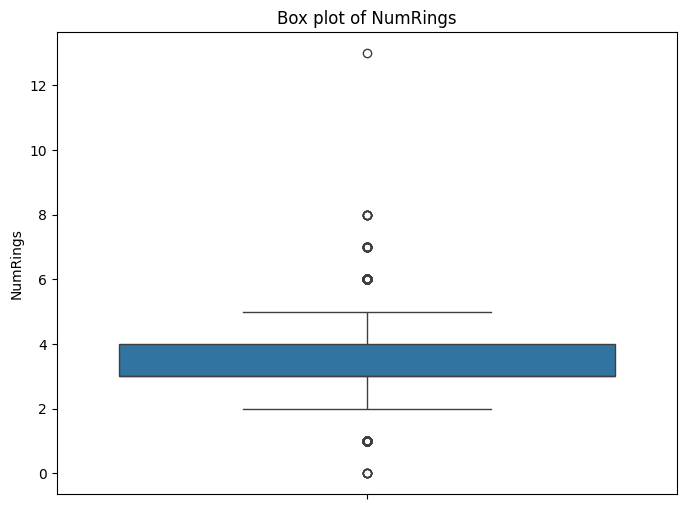

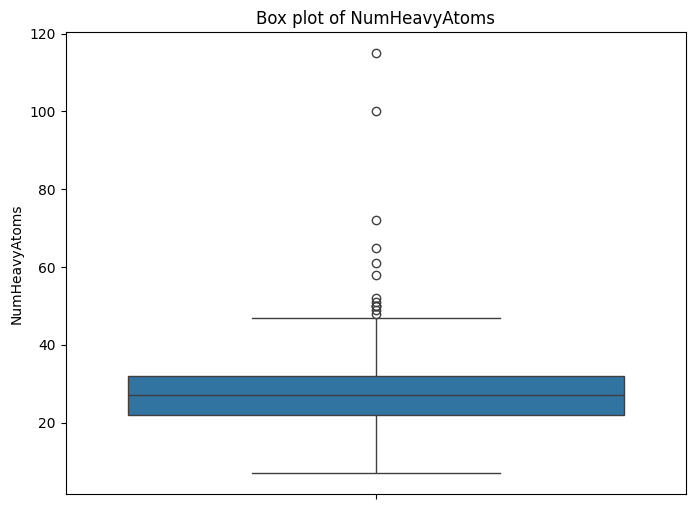

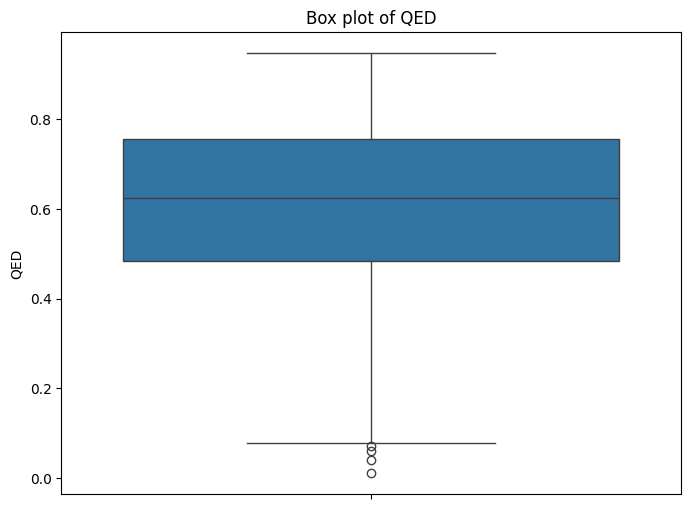

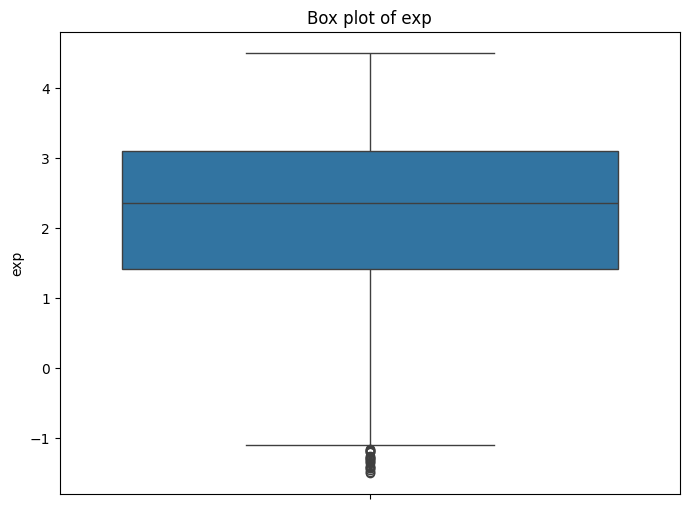

In [ ]:
# Cell 6: Check for missing values and outliers
def check_missing_values(data):
    missing_values = data.isnull().sum()
    total_missing_values = missing_values.sum()
    print("Total missing values:", total_missing_values)
    print("Missing values in each column:\n", missing_values)

def detect_outliers(df):
    outliers = {}
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
    return outliers

def visualize_outliers(data, columns):
    for column in columns:
        plt.figure(figsize=(8, 6))
        sns.boxplot(data[column])
        plt.title(f"Box plot of {column}")
        plt.show()

check_missing_values(data)
outliers = detect_outliers(data)
print("Number of outliers in each column:\n", outliers)
columns_to_plot = ['MolWt', 'TPSA', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds', 'NumRings', 'NumHeavyAtoms', 'QED', 'exp']
visualize_outliers(data, columns_to_plot)


The following cells address the outliers in the dataset:

- Identify and remove outliers using the Interquartile Range (IQR) method, filtering out data points beyond 1.5 times the IQR from Q1 and Q3.
- Caps extreme values in the `NumHAcceptors` column at the 95th percentile, replacing values above this threshold to reduce the impact of outliers.


In [ ]:
# Cell 7: Remove outliers and verify
def remove_outliers(df):
    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

data_cleaned = remove_outliers(data)
print("Data shape after removing outliers:", data_cleaned.shape)

outliers_after_cleaning = detect_outliers(data_cleaned)
print("Number of outliers in each column after cleaning:\n", outliers_after_cleaning)

total_missing_values_after_cleaning = data_cleaned.isnull().sum().sum()
print("Total missing values after cleaning:", total_missing_values_after_cleaning)

Data shape after removing outliers: (3669, 2223)
Number of outliers in each column after cleaning:
 {'MolWt': 6, 'TPSA': 2, 'NumHAcceptors': 60, 'NumHDonors': 0, 'NumRotatableBonds': 0, 'NumRings': 0, 'NumHeavyAtoms': 0, 'QED': 0, 'exp': 4}
Total missing values after cleaning: 0


In [ ]:
# Cell 8: Cap values and verify outliers
def cap_values(df, column, cap_percentile=0.95):
    cap_value = df[column].quantile(cap_percentile)
    df[column] = np.where(df[column] > cap_value, cap_value, df[column])
    return df

data_cleaned = cap_values(data_cleaned, 'NumHAcceptors')

outliers_after_capping = detect_outliers(data_cleaned)
print("Number of outliers in each column after capping:\n", outliers_after_capping)


Number of outliers in each column after capping:
 {'MolWt': 6, 'TPSA': 2, 'NumHAcceptors': 2, 'NumHDonors': 0, 'NumRotatableBonds': 0, 'NumRings': 0, 'NumHeavyAtoms': 0, 'QED': 0, 'exp': 4}


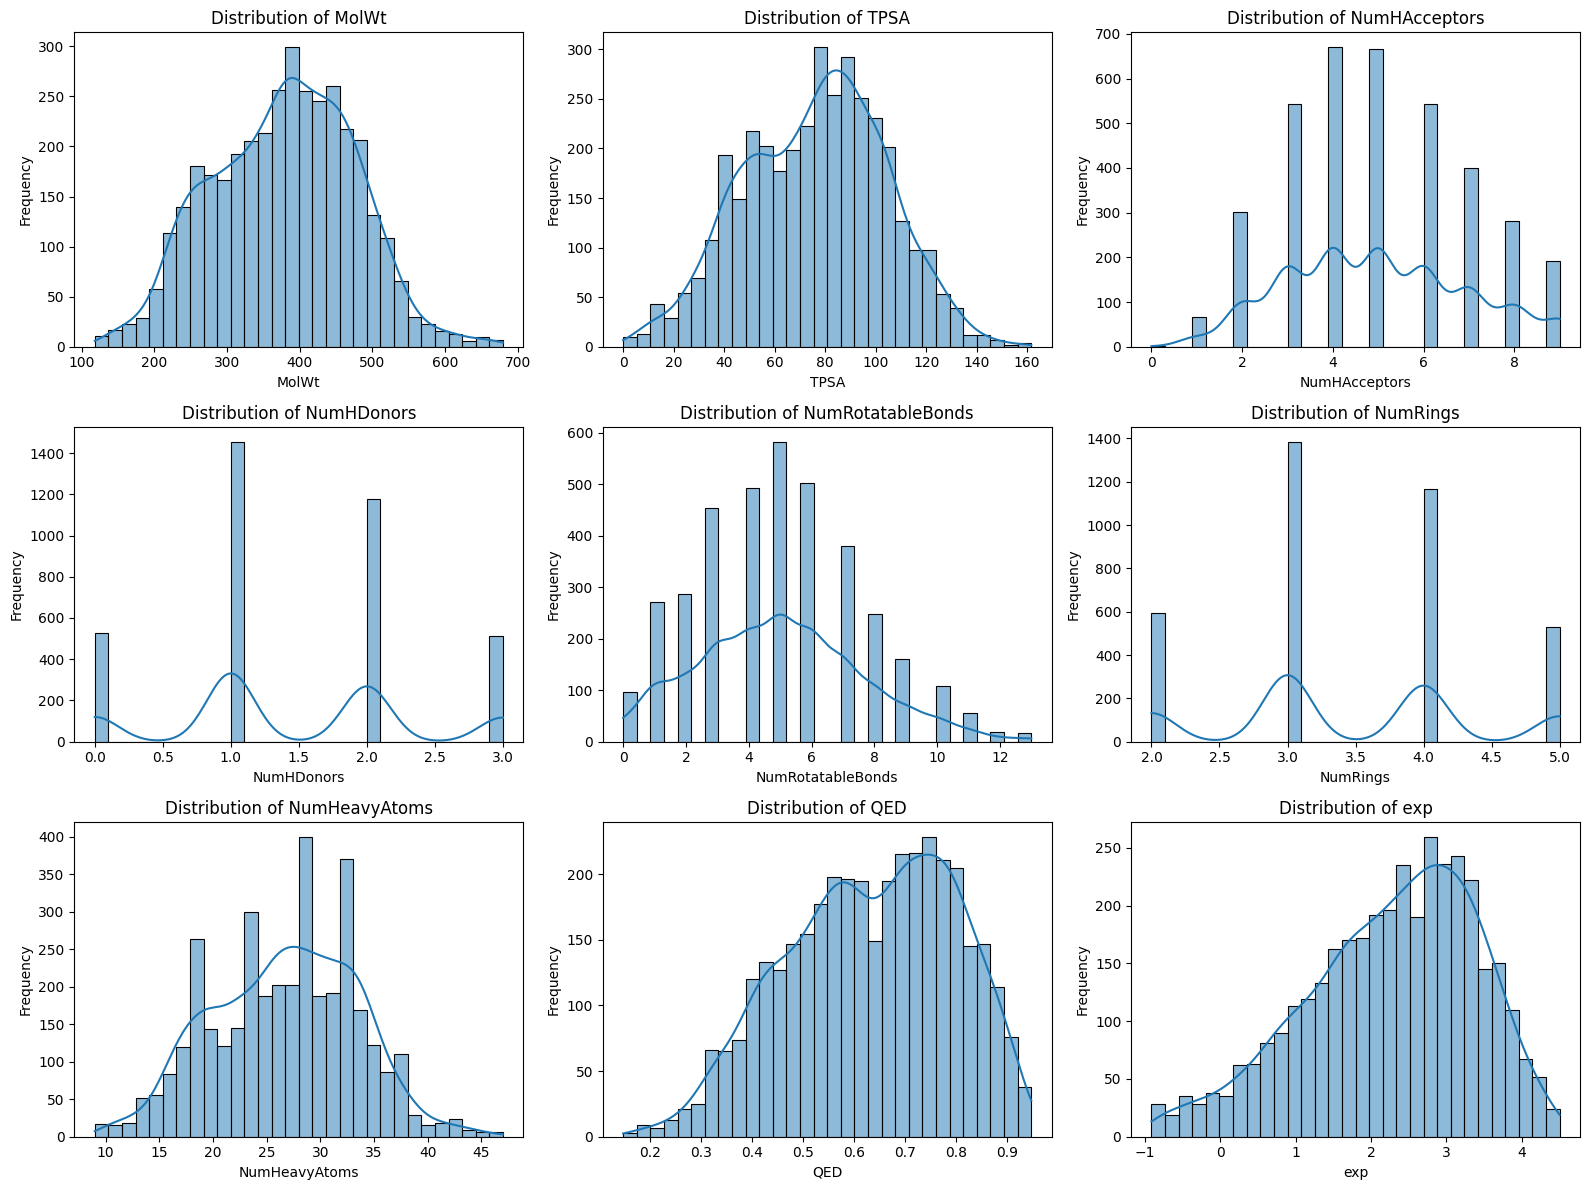

In [ ]:
# Cell 9: Visualize distributions of key descriptors
def visualize_distributions(data, columns):
    plt.figure(figsize=(16, 12))
    for i, column in enumerate(columns, 1):
        plt.subplot(3, 3, i)
        sns.histplot(data[column], bins=30, kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

key_descriptors = ['MolWt', 'TPSA', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds', 'NumRings', 'NumHeavyAtoms', 'QED', 'exp']
visualize_distributions(data_cleaned, key_descriptors)


Significant Pearson correlations (|R| > 0.6):
          Variable 1         Variable 2  Correlation
0              MolWt  NumRotatableBonds     0.770750
1              MolWt                QED    -0.648836
2      NumHAcceptors               TPSA     0.772078
3  NumRotatableBonds      NumHeavyAtoms     0.773558
4      NumHeavyAtoms              MolWt     0.975368
5      NumHeavyAtoms           NumRings     0.636693
6                QED              MolWt    -0.648836


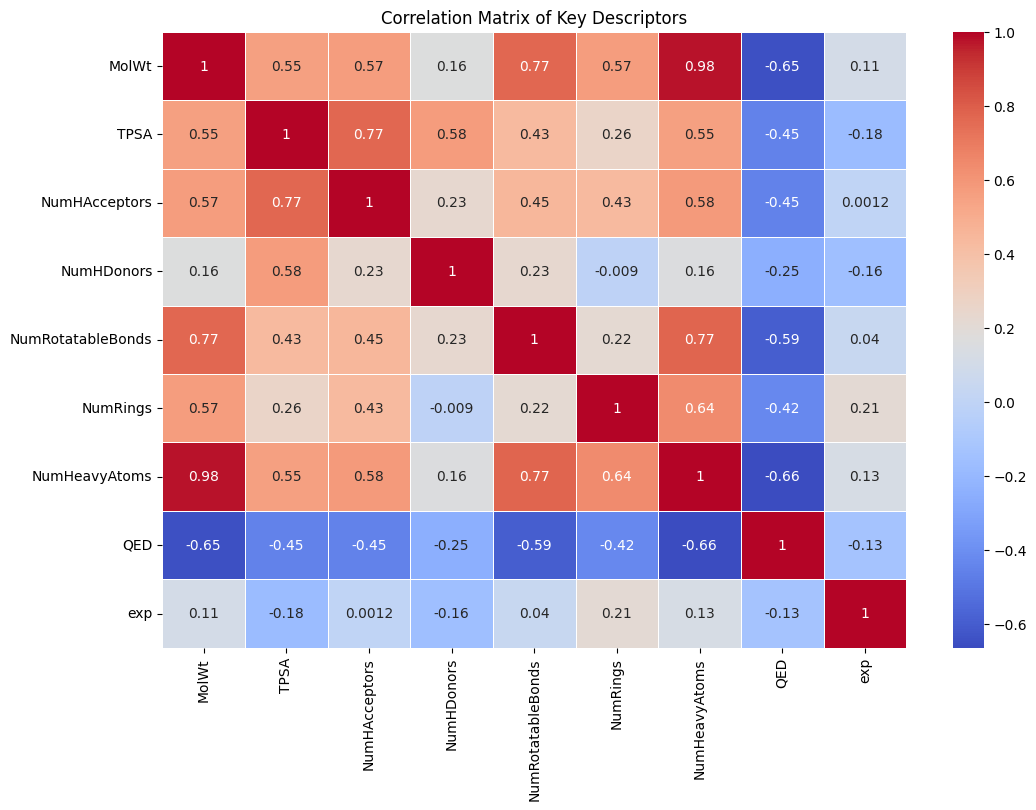

In [ ]:
# Cell 10: Correlation analysis
def correlation_analysis(data, columns, method='pearson'):
    corr_matrix = data[columns].corr(method=method)
    significant_corr = corr_matrix[(corr_matrix > 0.6) | (corr_matrix < -0.6)]
    significant_pairs = significant_corr.stack()
    significant_pairs = significant_pairs[significant_pairs.index.get_level_values(0) != significant_pairs.index.get_level_values(1)]
    significant_pairs = significant_pairs.reset_index()
    significant_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']
    significant_pairs = significant_pairs.loc[significant_pairs.index % 2 == 0].reset_index(drop=True)
    return significant_pairs, corr_matrix

def plot_heatmap(corr_matrix, title):
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title(title)
    plt.show()

significant_pearson_pairs, pearson_corr_matrix = correlation_analysis(data_cleaned, key_descriptors, method='pearson')
print("Significant Pearson correlations (|R| > 0.6):")
print(significant_pearson_pairs)
plot_heatmap(pearson_corr_matrix, 'Correlation Matrix of Key Descriptors')

The following pairplot provides some insight:

- **TPSA and MolWeight**: Larger molecules generally have more polar surface area, indicating a positive relationship.
  
- **NumAcceptors and TPSA**: More hydrogen bond acceptors correlate with a larger TPSA, reflecting increased polarity.
  
- **NumRotatableBonds and MolWeight**: Heavier molecules tend to have more rotatable bonds, indicating greater flexibility.
  
- **NumHeavyAtoms and MolWeight**: A strong positive correlation shows that heavier molecules have more heavy atoms.
  
- **MolWeight and QED**: A negative parabolic trend suggests that larger molecules are generally less drug-like, with a slight recovery at higher weights.
  
- **NumHeavyAtoms and QED**: Similar to MolWeight, more heavy atoms correlate with lower drug-likeness, showing a parabolic curve.
  
- **NumRotatableBonds and QED**: Increased flexibility (more rotatable bonds) is associated with lower drug-likeness.

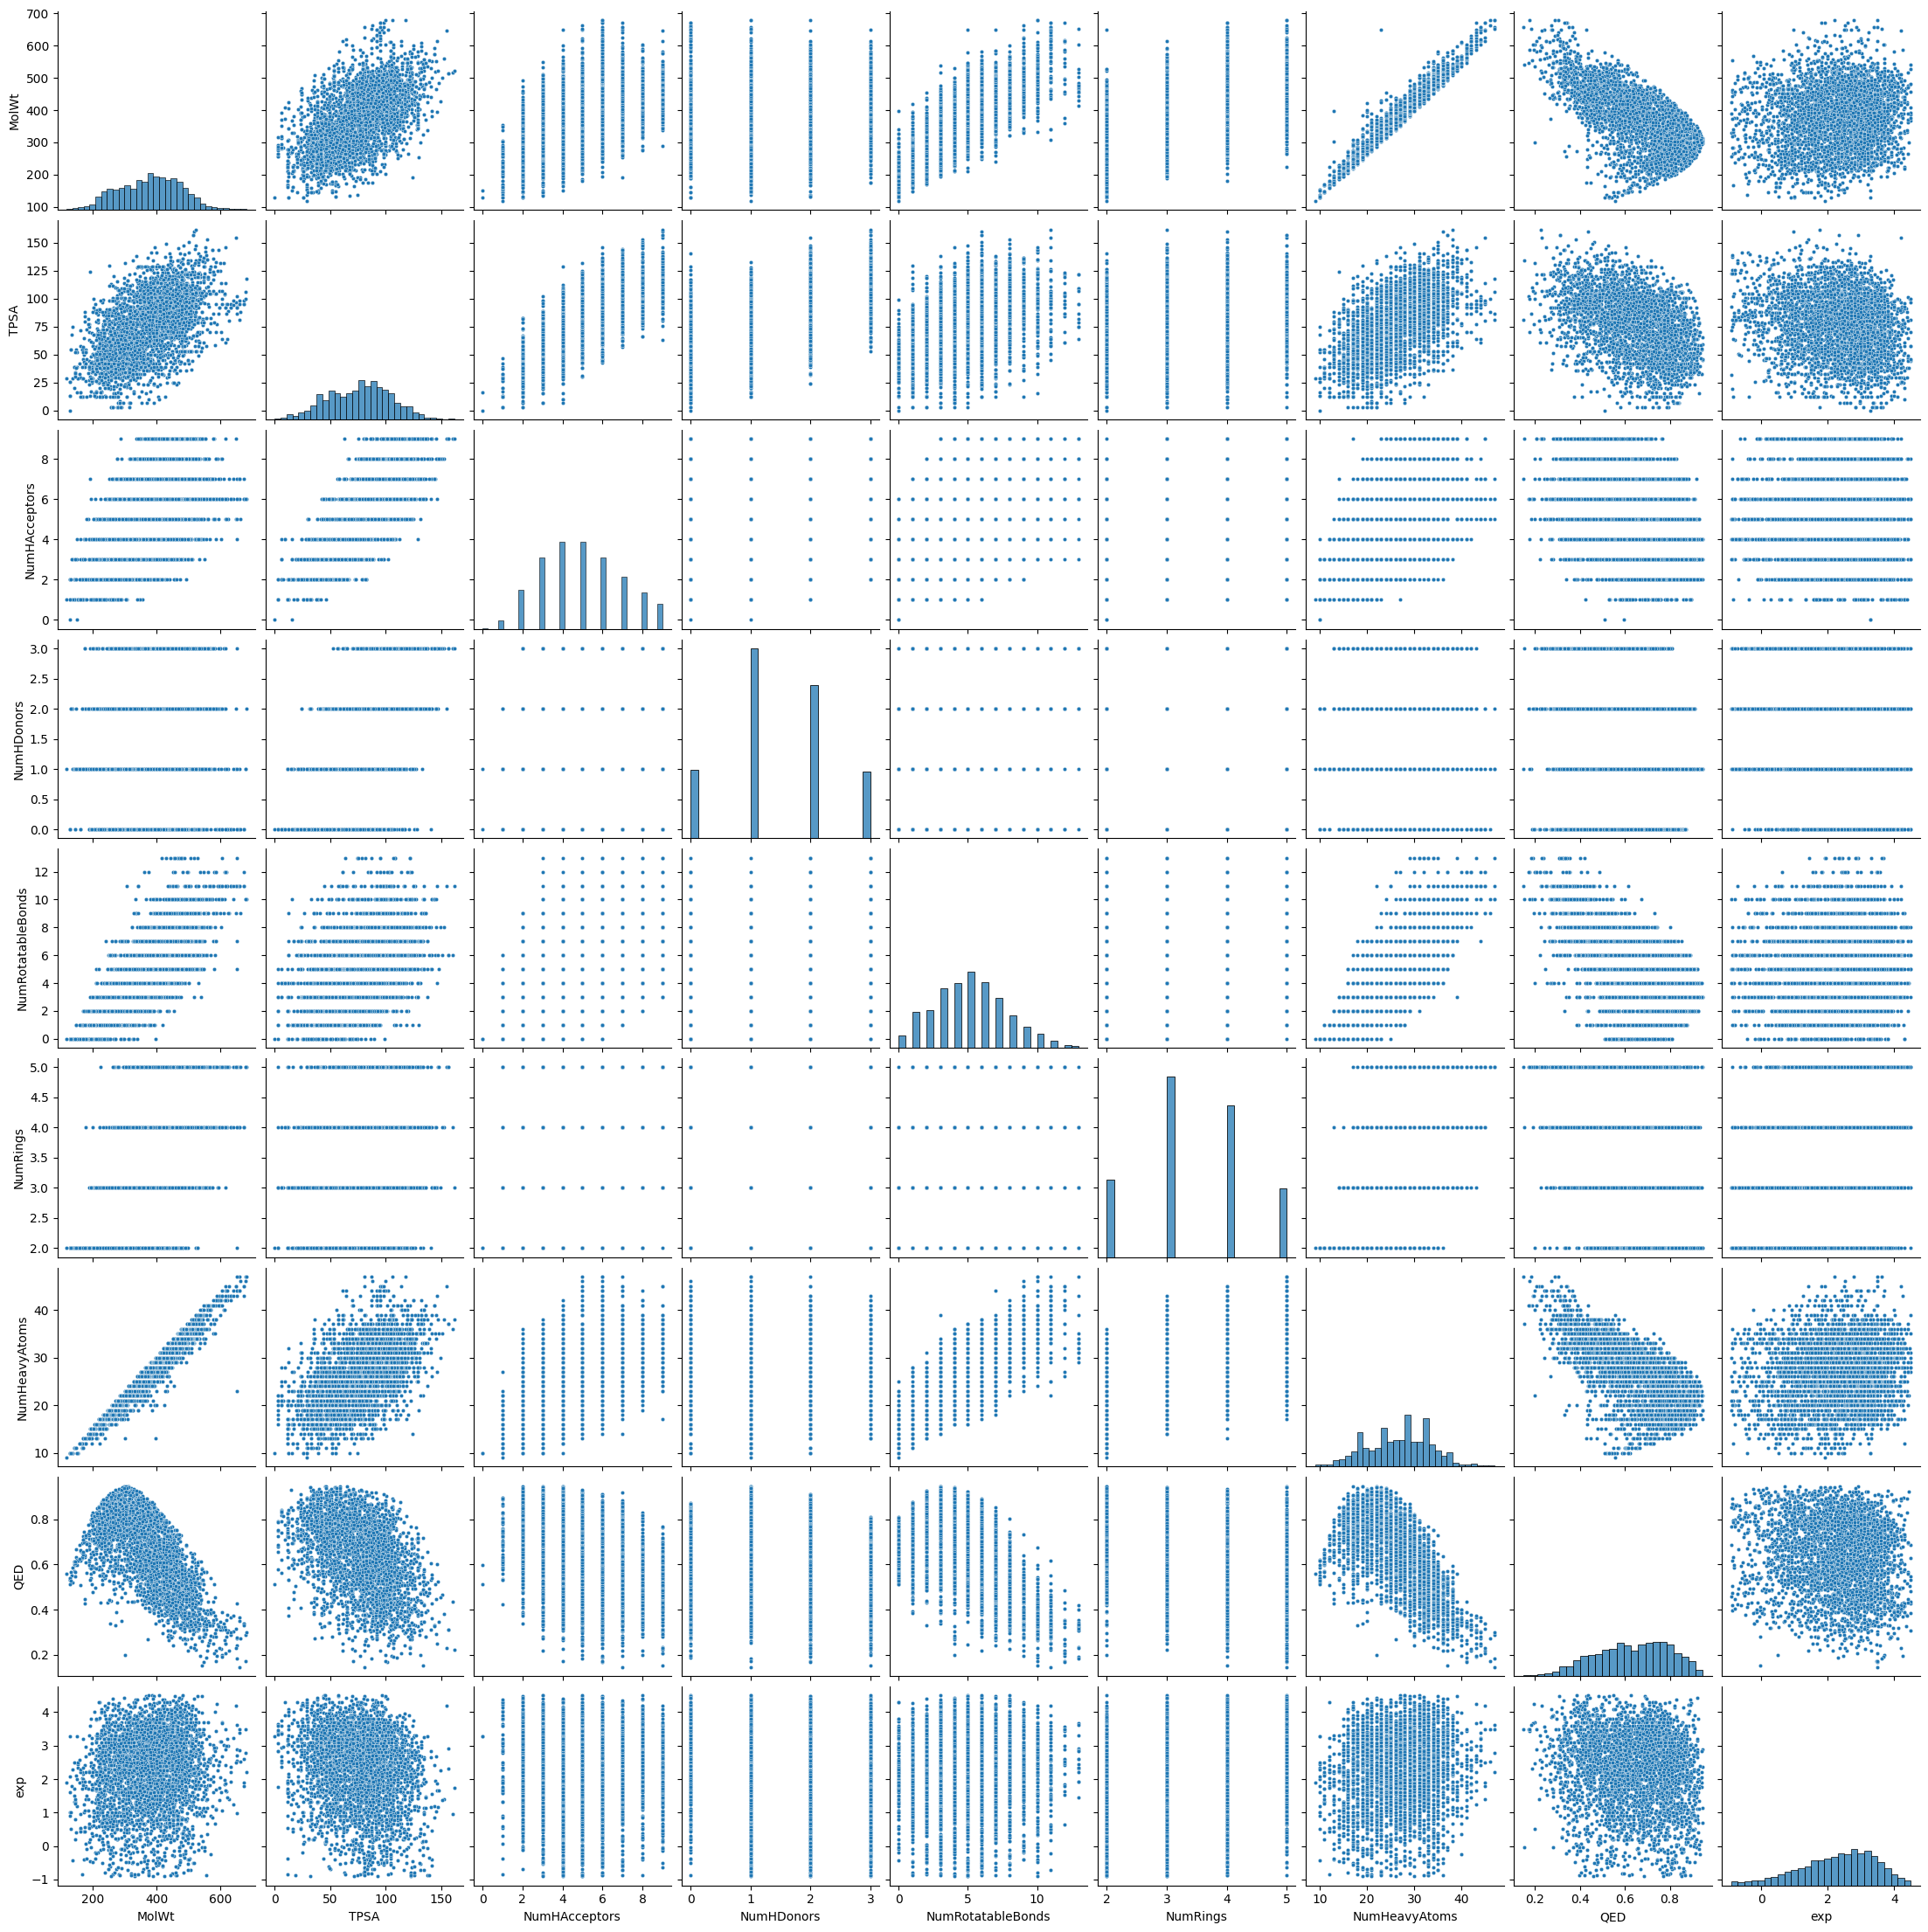

In [ ]:
# Cell 11: Pairplot
def plot_pairplot(data, columns):
    g = sns.pairplot(data[columns], plot_kws={'s': 10})
    plt.show()

plot_pairplot(data_cleaned, key_descriptors)

1. **TPSA_MolWeight**:
   - Reflects how the combined size and polar surface area impact lipophilicity, given their broad positive correlation.

2. **NumAcceptors_TPSA**:
   - Captures the relationship between polarity and hydrogen bond acceptors, both of which are strongly correlated and influence solubility and lipophilicity.

3. **NumRotatableBonds_MolWeight**:
   - Represents the interaction between molecular size and flexibility, as these two properties are positively correlated and jointly affect molecular behavior.

4. **MolWeight_QED**:
   - Accounts for the negative, parabolic relationship between molecular weight and drug-likeness, important for understanding how size affects drug potential.

5. **NumHeavyAtoms_QED**:
   - Captures the parabolic relationship between the number of heavy atoms and QED, similar to molecular weight, indicating how atom count impacts drug-likeness.

6. **NumRotatableBonds_QED**:
   - Reflects the negative correlation between molecular flexibility and drug-likeness, highlighting the effect of flexibility on lipophilicity.

7. **NumRotatableBonds_NumHeavyAtoms**:
   - Represents the relationship between flexibility and the number of heavy atoms, as these are positively correlated and jointly influence molecular stability and lipophilicity.

8. **NumHeavyAtoms_NumRings**:
   - Captures the relationship between the number of heavy atoms and rings, indicating structural complexity, which is positively correlated and influences lipophilicity.

9. **TPSA_to_MolWeight**:
   - Examines the relative contribution of polar surface area to molecular size, helping to understand the balance between these factors in influencing lipophilicity.

10. **NumAcceptors_to_TPSA**:
    - Assesses the proportion of hydrogen bond acceptors relative to polar surface area, which is important for predicting solubility and lipophilicity.

11. **NumRotatableBonds_to_MolWeight**:
    - Highlights the balance between flexibility and molecular size, indicating how these factors proportionally affect molecular behavior.

12. **NumRotatableBonds_to_NumHeavyAtoms**:
    - Shows the balance between flexibility and the number of heavy atoms, important for understanding molecular dynamics.

13. **NumHeavyAtoms_to_NumRings**:
    - Examines the ratio of heavy atoms to rings, reflecting the relationship between atom count and structural complexity.

14. **MolWeight_squared**:
    - Captures the non-linear, quadratic effect of molecular weight, allowing the model to understand how changes in size might have an accelerating or decelerating impact on the target variable.

15. **NumHeavyAtoms_squared**:
    - Models the quadratic relationship within QED, enabling the model to account for potential non-linear effects of drug-likeness on the outcome, such as diminishing returns or increased impact at higher values.

In [ ]:
# Cell 12: Feature engineering
def feature_engineering(df):
    df['TPSA_MolWeight'] = df['TPSA'] * df['MolWt']
    df['NumAcceptors_TPSA'] = df['NumHAcceptors'] * df['TPSA']
    df['NumRotatableBonds_MolWeight'] = df['NumRotatableBonds'] * df['MolWt']
    df['MolWeight_QED'] = df['MolWt'] * df['QED']
    df['NumHeavyAtoms_QED'] = df['NumHeavyAtoms'] * df['QED']
    df['NumRotatableBonds_QED'] = df['NumRotatableBonds'] * df['QED']
    df['NumRotatableBonds_NumHeavyAtoms'] = df['NumRotatableBonds'] * df['NumHeavyAtoms']
    df['NumHeavyAtoms_NumRings'] = df['NumHeavyAtoms'] * df['NumRings']

    df['TPSA_to_MolWeight'] = df['TPSA'] / (df['MolWt'] + 1)
    df['NumAcceptors_to_TPSA'] = df['NumHAcceptors'] / (df['TPSA'] + 1)
    df['NumRotatableBonds_to_MolWeight'] = df['NumRotatableBonds'] / (df['MolWt'] + 1)
    df['NumRotatableBonds_to_NumHeavyAtoms'] = df['NumRotatableBonds'] / (df['NumHeavyAtoms'] + 1)
    df['NumHeavyAtoms_to_NumRings'] = df['NumHeavyAtoms'] / (df['NumRings'] + 1)

    df['MolWeight_squared'] = df['MolWt'] ** 2
    df['QED_squared'] = df['QED'] ** 2

    return df

data_cleaned = feature_engineering(data_cleaned)


In [ ]:
# Cell 13: Standardize the features
def standardize_features(df, target_column):
    target = df[target_column]
    features = df.drop(columns=[target_column])

    scaler = StandardScaler()
    features_standardized = scaler.fit_transform(features)
    features_standardized = pd.DataFrame(features_standardized, columns=features.columns)

    print("Summary statistics of the standardized features:\n", features_standardized.describe())
    return features_standardized, target

features_standardized, target = standardize_features(data_cleaned, 'exp')

Summary statistics of the standardized features:
               MolWt          TPSA  NumHAcceptors    NumHDonors  \
count  3.669000e+03  3.669000e+03   3.669000e+03  3.669000e+03   
mean   2.382032e-16 -9.392565e-17   9.779888e-17  4.357376e-17   
std    1.000136e+00  1.000136e+00   1.000136e+00  1.000136e+00   
min   -2.670334e+00 -2.715364e+00  -2.523397e+00 -1.614485e+00   
25%   -7.389305e-01 -7.571977e-01  -5.059990e-01 -5.068662e-01   
50%    4.346767e-02  8.629811e-02  -1.649549e-03 -5.068662e-01   
75%    7.317682e-01  7.278402e-01   5.026999e-01  6.007527e-01   
max    3.094095e+00  3.051735e+00   2.015748e+00  1.708372e+00   

       NumRotatableBonds      NumRings  NumHeavyAtoms           QED  MACCS_1  \
count       3.669000e+03  3.669000e+03   3.669000e+03  3.669000e+03   3669.0   
mean        1.413726e-16  8.327429e-17  -2.081857e-16 -5.514501e-16      0.0   
std         1.000136e+00  1.000136e+00   1.000136e+00  1.000136e+00      0.0   
min        -1.905895e+00 -1.557946e

In [ ]:
# Cell 14: Feature selection based on importance threshold
def feature_selection_by_importance(features, target, threshold=0.0001):
    model_rf = RandomForestRegressor()
    model_rf.fit(features, target)
    importances = model_rf.feature_importances_
    feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': importances})
    important_features = feature_importances[feature_importances['Importance'] > threshold]['Feature']
    return features[important_features]

features_reduced = feature_selection_by_importance(features_standardized, target)
print(f"Number of features after reduction: {features_reduced.shape[1]}")

Number of features after reduction: 785


###Note on Hyperparameter Tuning

The hyperparameter tuning for the RandomForestRegressor and GradientBoostingRegressor models was conducted using GridSearchCV. Due to the extensive computational time required for this process, the grid searches were executed on my local machine and ran offline overnight.


In [ ]:
# Cell 15: Hyperparameter tuning fo RandomForestRegressor with GridSearchCV
# rf_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'criterion': ['squared_error'],
#     'max_features': ['sqrt', 'log2']
# }

# rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=rf_param_grid, cv=5, n_jobs=-1)
# rf_grid_search.fit(X_train, y_train)

# best_rf_model = rf_grid_search.best_estimator_

In [ ]:
# Cell 16: Train and evaluate RandomForestRegressor with reduced features
def train_and_evaluate_rf(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    rf_model = RandomForestRegressor(n_estimators=300, max_depth=None, criterion='squared_error', max_features='sqrt', random_state=42)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    cv_scores = cross_val_score(rf_model, features, target, cv=5)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    n = len(y_test)
    model = sm.OLS(y_test, sm.add_constant(y_pred)).fit()
    aic = model.aic
    bic = model.bic

    print(f"Random Forest - Cross-Validation Scores: {cv_scores}")
    print(f"Random Forest - Mean Squared Error: {mse}")
    print(f"Random Forest - Root Mean Squared Error: {rmse}")
    print(f"Random Forest - R-squared: {r2}")
    print(f"Random Forest - Mean Absolute Error: {mae}")
    print(f"Random Forest - AIC: {aic}")
    print(f"Random Forest - BIC: {bic}")

train_and_evaluate_rf(features_reduced, target)

Random Forest - Cross-Validation Scores: [0.61998711 0.57999548 0.57711772 0.57430584 0.58456135]
Random Forest - Mean Squared Error: 0.4532280584998465
Random Forest - Root Mean Squared Error: 0.6732221464716134
Random Forest - R-squared: 0.6150952098074605
Random Forest - Mean Absolute Error: 0.5258597215914828
Random Forest - AIC: 1426.3709819259057
Random Forest - BIC: 1435.5679999831348


In [ ]:
# Cell 17: Feature selection for GradientBoostingRegressor
def feature_selection_gb(features, target, threshold=0.0005):
    prelim_gb_model = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=7, criterion='squared_error', max_features='sqrt', random_state=42)
    prelim_gb_model.fit(features, target)
    importances = prelim_gb_model.feature_importances_
    feature_importances = pd.DataFrame({'Feature': features.columns, 'Importance': importances})
    important_features = feature_importances[feature_importances['Importance'] > threshold]['Feature']
    return features[important_features]

features_gb_reduced = feature_selection_gb(features_standardized, target)
print(f"Number of features after reduction for Gradient Boosting: {features_gb_reduced.shape[1]}")


Number of features after reduction for Gradient Boosting: 365


In [ ]:
# Cell 18: Hyperparameter tuning fo GradientBoostingRegressor with GridSearchCV
# gb_param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 5, 7],
#     'criterion': ['squared_error'],
#     'max_features': ['sqrt', 'log2']
# }

# gb_grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=gb_param_grid, cv=5, n_jobs=-1)
# gb_grid_search.fit(X_train, y_train)

In [ ]:
# Cell 19: Train and evaluate GradientBoostingRegressor with reduced features
def train_and_evaluate_gb(features, target):
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
    gb_model = GradientBoostingRegressor(n_estimators=400, learning_rate=0.1, max_depth=7, criterion='squared_error', max_features='sqrt', random_state=42)
    gb_model.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)

    cv_scores = cross_val_score(gb_model, features, target, cv=5)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    model = sm.OLS(y_test, sm.add_constant(y_pred)).fit()
    aic = model.aic
    bic = model.bic

    print(f"Gradient Boosting - Cross-Validation Scores: {cv_scores}")
    print(f"Gradient Boosting - Mean Squared Error: {mse}")
    print(f"Gradient Boosting - Root Mean Squared Error: {rmse}")
    print(f"Gradient Boosting - R-squared: {r2}")
    print(f"Gradient Boosting - Mean Absolute Error: {mae}")
    print(f"Gradient Boosting - AIC: {aic}")
    print(f"Gradient Boosting - BIC: {bic}")

train_and_evaluate_gb(features_gb_reduced, target)


Gradient Boosting - Cross-Validation Scores: [0.69085296 0.67126463 0.67200273 0.66375454 0.67678899]
Gradient Boosting - Mean Squared Error: 0.352440048806208
Gradient Boosting - Root Mean Squared Error: 0.5936666141920126
Gradient Boosting - R-squared: 0.7006896186211122
Gradient Boosting - Mean Absolute Error: 0.4573320343659426
Gradient Boosting - AIC: 1313.2422424477847
Gradient Boosting - BIC: 1322.4392605050139


In the context of predicting lipophilicity (logD) of molecules, Gradient Boosting has demonstrated superior performance compared to Random Forest.

1. **Cross-Validation Scores:**
   - **Random Forest:** [0.6199, 0.5800, 0.5771, 0.5743, 0.5846]
   - **Gradient Boosting:** [0.6909, 0.6713, 0.6720, 0.6638, 0.6768]
   
   The cross-validation scores for Gradient Boosting are consistently higher than those for Random Forest, indicating better generalization to unseen data.

2. **Mean Squared Error (MSE):**
   - **Random Forest:** 0.4532
   - **Gradient Boosting:** 0.3524
   
   The lower MSE of the Gradient Boosting model indicates that it produces predictions closer to the actual values, leading to better overall accuracy.

3. **Root Mean Squared Error (RMSE):**
   - **Random Forest:** 0.6732
   - **Gradient Boosting:** 0.5937
   
   The RMSE follows the trend of MSE, further confirming that the predictions of the Gradient Boosting model have smaller deviations from the true values.

4. **R-squared (R²):**
   - **Random Forest:** 0.6151
   - **Gradient Boosting:** 0.7007
   
   A higher R² value for Gradient Boosting indicates that this model explains more of the variance in the data compared to Random Forest.

5. **Mean Absolute Error (MAE):**
   - **Random Forest:** 0.5259
   - **Gradient Boosting:** 0.4573
   
   The lower MAE for Gradient Boosting suggests that, on average, its predictions are closer to the true values than those of Random Forest.

6. **Akaike Information Criterion (AIC):**
   - **Random Forest:** 1426.37
   - **Gradient Boosting:** 1313.24
   
   The lower AIC score for Gradient Boosting indicates that it is a better model, balancing the trade-off between goodness-of-fit and model complexity.

7. **Bayesian Information Criterion (BIC):**
   - **Random Forest:** 1435.57
   - **Gradient Boosting:** 1322.44
   
   Similar to AIC, the lower BIC score for Gradient Boosting further emphasizes its superiority in terms of model selection criteria, penalizing the model complexity more heavily.

# Conclusion

The superior performance of the Gradient Boosting model in predicting lipophilicity is due to its ability to capture complex, non-linear relationships and interactions between molecular descriptors. Its iterative approach to error reduction allows it to produce more accurate and reliable predictions than Random Forest. The consistently lower error metrics (MSE, RMSE, MAE) and better model selection criteria (AIC, BIC) underscore Gradient Boosting's effectiveness for this task.